# Forecasting with Dynamic Linear Model (DLM)

Among state space models, Dynamic Linear Model (DLM) are one of the most popular models due to its explainability and ability to incorporate regressors with dynamic coefficients. This notebook introduces a way to construct a vanlia DLM through Pyro and Forecaster modules. 

See also:
- [Forecasting II: state space models](http://pyro.ai/examples/forecasting_ii.html)

#### Summary 
1. data simulation
2. visualization of coefficients and response
3. model training and validation
    - posteriors comparison
    - holdout validation
4. incorporating coefficients priors at various time points

In [644]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.stats import quantile

%matplotlib inline
assert pyro.__version__.startswith('1.4.0')

pyro.enable_validation(True)
pyro.set_rng_seed(20200221)
np.random.seed(2020)

pd.set_option('display.max_rows', 500)
plt.style.use('fivethirtyeight')

## Data Simulation

Assume we have observation $y_t$ at time $t$ such that 
$$y_t = x_t^T \beta_t + \epsilon_t$$
$$\beta_t = \beta_{t-1} + \delta_t$$
where

$x_t$ is a P x 1 vector of regressors at time $t$

$\beta_t$ is a P x 1 vector of latent coefficients at time $t$ following a random walk distribution

$\epsilon$ is the noise at time $t$

We then simulate data in following distribution:
$$x_t \sim \mathcal{N}_p(0, \sigma_x^2)$$
$$\delta_t \sim \mathcal{N}_p(0, \sigma_{\delta}^2)$$
$$\epsilon_t \sim \mathcal{N}(0, \sigma_y^2)$$

In [641]:
# number of predictors, total observations
p = 3
n = 720

# start, train end, test end
T0 = 0            
T1 = n - 30
T2 = n

# initializing coefficients at zeros, simulate all coefficient values
beta0 = torch.from_numpy(np.cumsum(np.random.normal(0, 0.1, n))).unsqueeze(-1)
betas_p = torch.from_numpy(np.cumsum(np.random.normal(0, 0.1, size=(n, p)), axis=0))
betas = torch.cat([beta0, betas_p], dim=-1)

# simulate regressors
covariates = torch.cat(
    [torch.ones(n, 1), torch.from_numpy(np.random.normal(2, 1, size=(n, p)))],
    dim=-1
)
# observation with noise
y = ((covariates * betas).sum(-1) + torch.from_numpy(np.random.normal(0, 0.5, n))).unsqueeze(-1)

## Visualization of response and coefficients

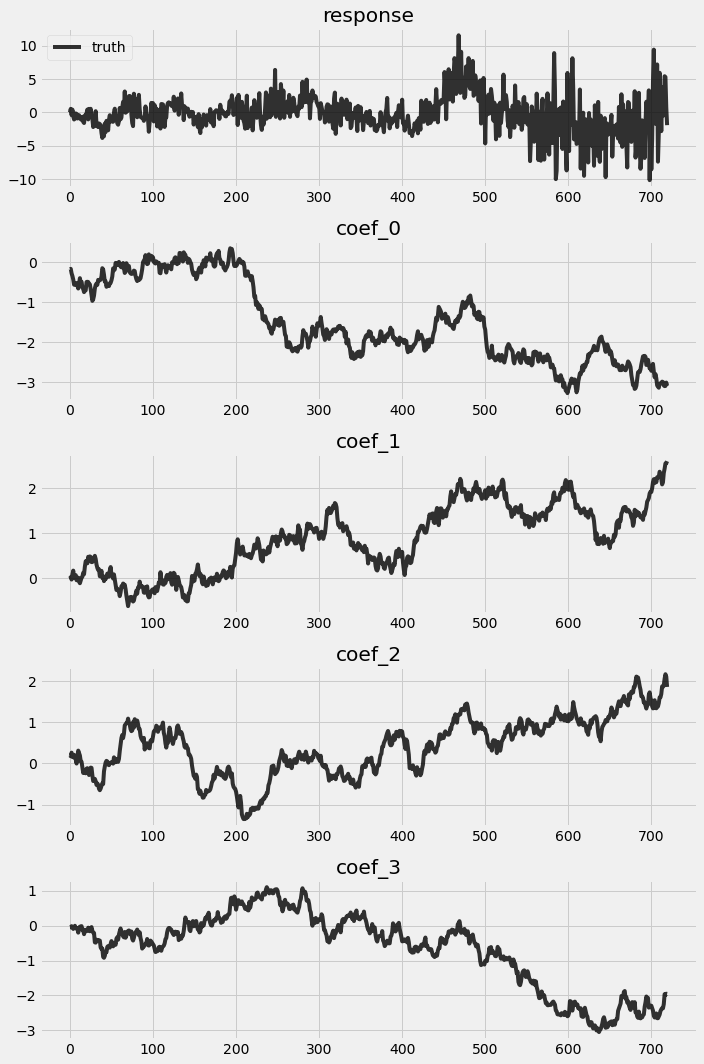

In [653]:
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y, 'k-', label='truth', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

## Train a vanlia DLM

In [654]:
class DLM(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
        
        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace 
        pyro.deterministic("weight", weight)
#         for t, prior in zip(time_points, priors):
#             pyro.sample("weight_prior_{}".format(t), dist.Normal(prior, 1e-1).to_event(1), obs=weight[..., t:t+1, :]) 

        prediction = (weight * covariates).sum(-1, keepdim=True) 
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace 
        pyro.deterministic("prediction", prediction)
        
        scale = pyro.sample("noise_scale", dist.LogNormal(-10, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)       

In [655]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
forecaster = Forecaster(DLM(), y[:T1], covariates[:T1], learning_rate=0.1, num_steps=1000)

INFO:root:Guessed max_plate_nesting = 1
INFO:pyro.contrib.forecast.forecaster:step    0 loss = 4.31067e+12
INFO:pyro.contrib.forecast.forecaster:step  100 loss = 25.1778
INFO:pyro.contrib.forecast.forecaster:step  200 loss = 8.40892
INFO:pyro.contrib.forecast.forecaster:step  300 loss = 3.77846
INFO:pyro.contrib.forecast.forecaster:step  400 loss = 2.57534
INFO:pyro.contrib.forecast.forecaster:step  500 loss = 2.3256
INFO:pyro.contrib.forecast.forecaster:step  600 loss = 2.37069
INFO:pyro.contrib.forecast.forecaster:step  700 loss = 2.63515
INFO:pyro.contrib.forecast.forecaster:step  800 loss = 2.76522
INFO:pyro.contrib.forecast.forecaster:step  900 loss = 2.5597


CPU times: user 8.2 s, sys: 53.4 ms, total: 8.26 s
Wall time: 8.31 s


## Posteriors comparison

We extract posteriors during the in-sample period and compare them against the truth.

In [656]:
num_samples = 100
dim = -2
with torch.no_grad():
    # record the VI samples from the guide
    with poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.guide(y[:T1], covariates[:T1])
    guide_trace = tr.trace

    # replay the model against the posteriors samples
    with poutine.replay(trace=guide_trace), poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.model(y[:T1], covariates[:T1])

    # extract the values from the recorded 
    posterior_samples = {
        name: site["value"]
        for name, site in tr.trace.nodes.items()
        if site["type"] == "sample"
    }
    
prediction = posterior_samples["prediction"].median(0).values
posterior_weight_mean = posterior_samples['weight'].median(0).values

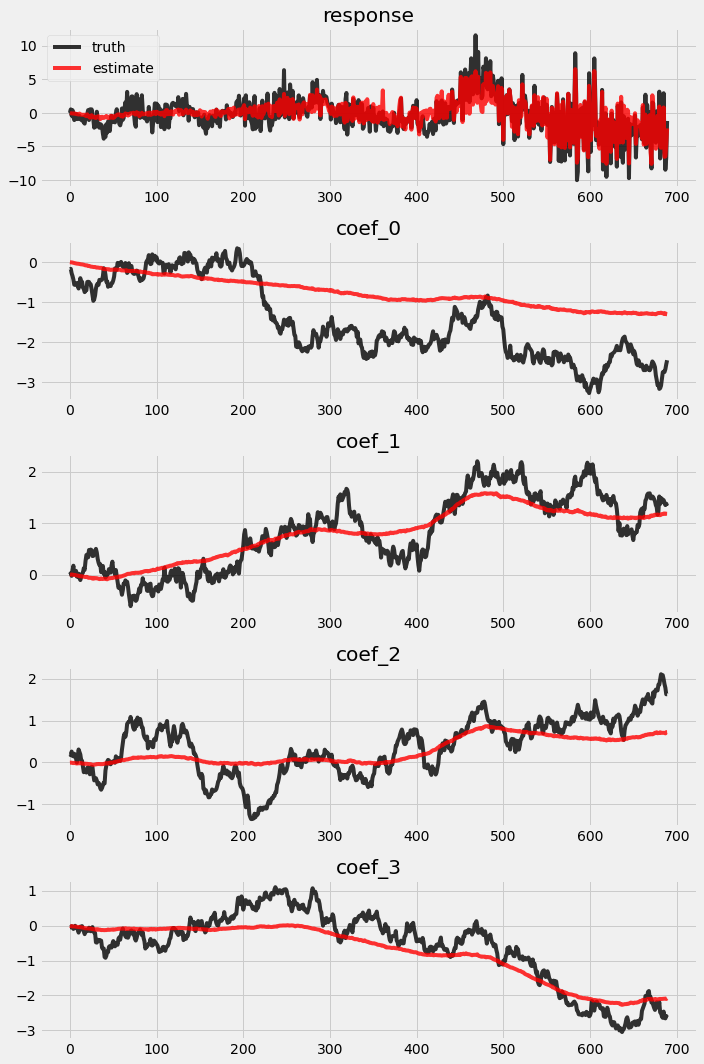

In [658]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], 'k-', label='truth', alpha=.8)
        axes[0].plot(prediction, 'r-', label='estimate', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].plot(posterior_weight_mean[:, idx - 1], 'r-', label='estimate', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

## Holdout validation

torch.Size([1000, 30, 1]) torch.Size([30])


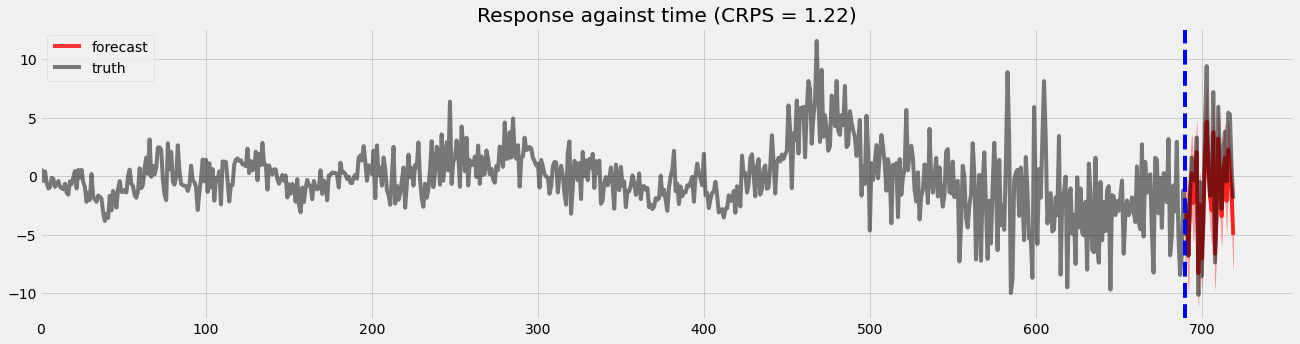

In [660]:
samples = forecaster(y[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, y[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast', alpha=.8)
plt.plot(y, 'k-', label='truth', alpha=.5)
plt.title("Response against time (CRPS = {:0.3g})".format(crps))
plt.xlim(0, None)
plt.axvline(T1, color='b', linestyle='--')
plt.legend(loc="best");

## Train a DLM with coefficients priors at various time points

In [661]:
# let's provide some priors
time_points = [100, 150, 200, 250, 300, 350, 400, 500, 600]
priors = betas[time_points, :]
priors.shape

torch.Size([9, 4])

In [662]:
class DLM2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
        
        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace 
        pyro.deterministic("weight", weight)
        for t, prior in zip(time_points, priors):
            pyro.sample("weight_prior_{}".format(t), dist.Normal(prior, 1e-1).to_event(1), obs=weight[..., t:t+1, :]) 

        prediction = (weight * covariates).sum(-1, keepdim=True) 
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace 
        pyro.deterministic("prediction", prediction)
        
        scale = pyro.sample("noise_scale", dist.LogNormal(-10, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)       

In [663]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
forecaster = Forecaster(DLM2(), y[:T1], covariates[:T1], learning_rate=0.1, num_steps=1000)

INFO:root:Guessed max_plate_nesting = 1
INFO:pyro.contrib.forecast.forecaster:step    0 loss = 4.31067e+12
INFO:pyro.contrib.forecast.forecaster:step  100 loss = 25.5124
INFO:pyro.contrib.forecast.forecaster:step  200 loss = 9.01633
INFO:pyro.contrib.forecast.forecaster:step  300 loss = 4.36909
INFO:pyro.contrib.forecast.forecaster:step  400 loss = 3.52124
INFO:pyro.contrib.forecast.forecaster:step  500 loss = 2.83259
INFO:pyro.contrib.forecast.forecaster:step  600 loss = 2.9854
INFO:pyro.contrib.forecast.forecaster:step  700 loss = 3.24708
INFO:pyro.contrib.forecast.forecaster:step  800 loss = 3.06119
INFO:pyro.contrib.forecast.forecaster:step  900 loss = 3.15238


CPU times: user 11.1 s, sys: 51.9 ms, total: 11.1 s
Wall time: 11.2 s


In [664]:
num_samples = 100
dim = -2
with torch.no_grad():
    # record the VI samples from the guide
    with poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.guide(y[:T1], covariates[:T1])
    guide_trace = tr.trace

    # replay the model against the posteriors samples
    with poutine.replay(trace=guide_trace), poutine.trace() as tr:
        with pyro.plate("particles", num_samples, dim=dim):
            forecaster.model(y[:T1], covariates[:T1])

    # extract the values from the recorded 
    posterior_samples = {
        name: site["value"]
        for name, site in tr.trace.nodes.items()
        if site["type"] == "sample"
    }
    
prediction = posterior_samples["prediction"].median(0).values
posterior_weight_mean = posterior_samples['weight'].median(0).values

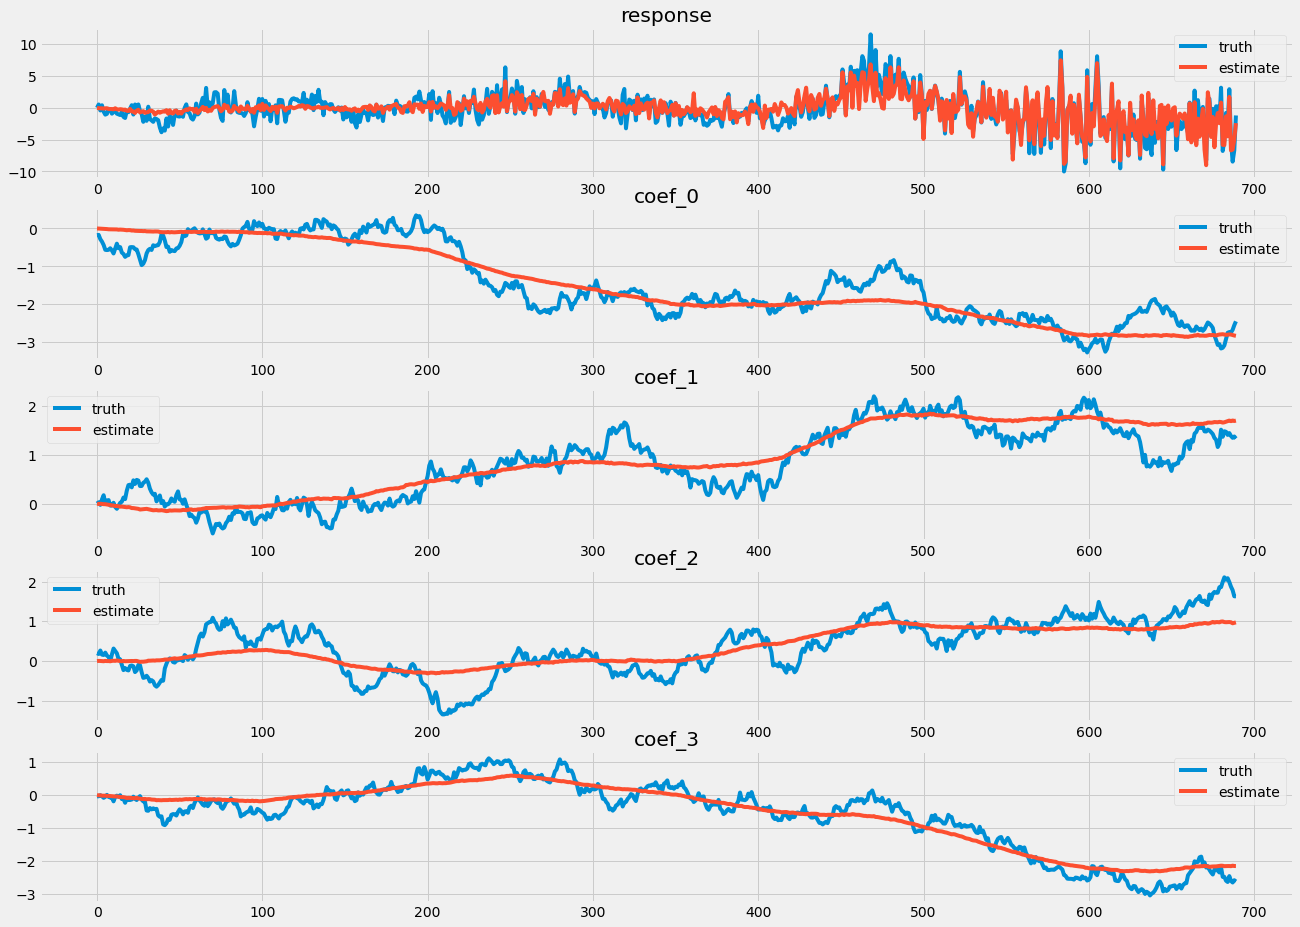

In [665]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(20, 3 * (p + 2)))

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], label='truth')
        axes[0].plot(prediction, label='estimate')
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx -  1], label='truth')
        axes[idx].plot(posterior_weight_mean[:, idx - 1], label='estimate')
        axes[idx].legend()
        axes[idx].set_title('coef_{}'.format(idx - 1))